# Problem Statement

In this project, we aim to predict the **exact quality score of red wine**, ranging from **3 to 8**, based on physicochemical test data such as acidity, sugar levels, pH, and alcohol content. 

Unlike traditional regression approaches, we reframe this task as a **multi-class classification problem** where each class corresponds to a specific quality score. This framing allows for better interpretability and supports real-world applications where wines are often graded into discrete quality categories.

Our goal is to build a robust predictive model that can assist wineries in estimating the expected quality of a wine early in the production pipeline.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [7]:
# Load the dataset
df = pd.read_csv("winequality-red.csv")

# Exploratory Data Analysis

We begin with a visual and statistical exploration of the dataset to understand how each feature correlates with wine quality. This helps guide both feature selection and model design.

We analyze:
- Distribution of quality scores (to reveal class imbalance)


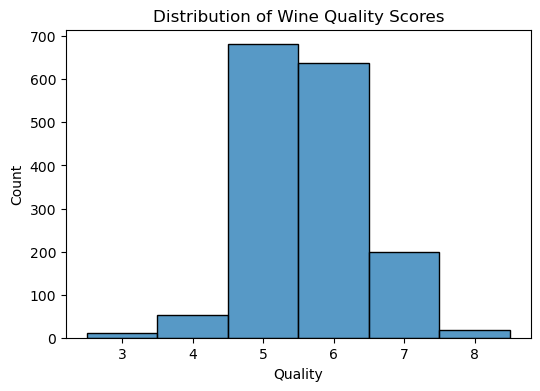

In [8]:
# Distribution
plt.figure(figsize=(6, 4))
sns.histplot(df['quality'], bins=range(3, 10), discrete=True)
plt.title("Distribution of Wine Quality Scores")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()